# Common DEGs and core-accessory genes

This notebook looks to see if the common DEGs, identified using the [SOPHIE](https://github.com/greenelab/generic-expression-patterns) approach are mostly core or accessory genes. The scripts to run SOPHIE were copied into this directory to run the analysis on the PAO1 and PA14 RNA-seq compendia.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from scripts import utils, paths

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


### Get common DEGs

In [2]:
# Load summary statistics generated by SOPHIE using the PAO1 and PA
pao1_common_DEGs_filename = "find_common_DEGs/generic_gene_summary_SRP117105.tsv"
pa14_common_DEGs_filename = "find_common_DEGs/generic_gene_summary_SRP074292.tsv"


pao1_SOPHIE_stats = pd.read_csv(
    pao1_common_DEGs_filename, sep="\t", index_col=0, header=0
)
pa14_SOPHIE_stats = pd.read_csv(
    pa14_common_DEGs_filename, sep="\t", index_col=0, header=0
)

In [3]:
print(pao1_SOPHIE_stats.shape)
pao1_SOPHIE_stats.head()

(5563, 14)


,Gene ID,Adj P-value (Real),Rank (Real),abs(log2FoldChange) (Real),log2FoldChange (Real),Median adj p-value (simulated),Rank (simulated),Percentile (simulated),Percent DE (simulated),Mean abs(log2FoldChange) (simulated),Std deviation (simulated),Number of experiments (simulated),Z score,Gene Name
PA3328,PA3328,4.917896e-25,5563.0,4.298007,4.298007,0.999256,5488.0,98.651564,0.0,0.340896,0.202712,25,19.520883,NaN
PA2303,PA2303,1.487221e-29,5562.0,4.048551,4.048551,0.999672,5445.0,97.878461,0.0,0.266379,0.168746,25,22.413449,ambD
PA4211,PA4211,2.207451e-24,5561.0,3.976647,3.976647,0.682754,5553.0,99.820209,0.0,0.453517,0.274850,25,12.818364,phzB1
PA3332,PA3332,2.012572e-11,5560.0,3.946715,3.946715,0.999256,5500.0,98.867314,0.0,0.294430,0.185347,25,19.705152,NaN
PA1431,PA1431,8.933852e-68,5559.0,3.730831,3.730831,0.999672,4915.0,88.349515,0.0,0.178405,0.165709,25,21.437724,rsaL


In [4]:
print(pa14_SOPHIE_stats.shape)
pa14_SOPHIE_stats.head()

(5887, 14)


,Gene ID,Adj P-value (Real),Rank (Real),abs(log2FoldChange) (Real),log2FoldChange (Real),Median adj p-value (simulated),Rank (simulated),Percentile (simulated),Percent DE (simulated),Mean abs(log2FoldChange) (simulated),Std deviation (simulated),Number of experiments (simulated),Z score,Gene Name
PA14_53300,PA14_53300,3.047746e-44,5886.0,3.820621,-3.820621,0.376356,5100.0,86.629290,0.04,0.328857,0.288167,25,12.117160,NaN
PA14_19590,PA14_19590,1.033915e-11,5885.0,3.739353,3.739353,0.418500,5305.0,90.112130,0.04,0.344072,0.270764,25,12.539610,NaN
PA14_01720,PA14_01720,2.888309e-49,5884.0,3.676547,-3.676547,0.457294,2910.0,49.422358,0.04,0.240304,0.279782,25,12.281857,NaN
PA14_21530,PA14_21530,1.439995e-28,5883.0,3.273061,-3.273061,0.808891,4750.0,80.682977,0.00,0.282720,0.275381,25,10.858940,NaN
PA14_71110,PA14_71110,1.432568e-07,5882.0,3.252741,-3.252741,0.978880,3574.0,60.703364,0.00,0.193255,0.179803,25,17.015766,NaN


In [5]:
# Get common DEGs (i.e. those that have a percentile above 80)
# Note: these are genes identified as commonly DE by SOPHIE, we don't have a manual reference
pao1_common_DEGs = pao1_SOPHIE_stats[
    pao1_SOPHIE_stats["Percentile (simulated)"] >= 80
].index
pa14_common_DEGs = pa14_SOPHIE_stats[
    pa14_SOPHIE_stats["Percentile (simulated)"] >= 80
].index

### Get core/accessory annotations

In [6]:
# Read in expression data
pao1_expression_filename = paths.PAO1_COMPENDIUM
pa14_expression_filename = paths.PA14_COMPENDIUM

pao1_expression = pd.read_csv(pao1_expression_filename, sep="\t", index_col=0, header=0)
pa14_expression = pd.read_csv(pa14_expression_filename, sep="\t", index_col=0, header=0)

Note: Core and accessory annotations are from [BACTOME](https://academic.oup.com/nar/article/47/D1/D716/5112984). Not all core genes are measured by our expression dataset ("my dataset") we're using, so there may be a difference in "Number of PAO1 core genes" (core genes from BACTOME) and "Number of PAO1 core genes in my dataset" (core genes that are found in my expression dataset.

In [7]:
pao1_annot_filename = paths.GENE_PAO1_ANNOT
pa14_annot_filename = paths.GENE_PA14_ANNOT

core_acc_dict = utils.get_my_core_acc_genes(
    pao1_annot_filename, pa14_annot_filename, pao1_expression, pa14_expression
)

Number of PAO1 core genes: 5366
Number of PA14 core genes: 5363
Number of PAO1 core genes in my dataset: 5361
Number of PA14 core genes in my dataset: 5361
Number of PAO1-specific genes: 202
Number of PA14-specific genes: 530


In [8]:
pao1_core = core_acc_dict["core_pao1"]
pa14_core = core_acc_dict["core_pa14"]
pao1_acc = core_acc_dict["acc_pao1"]
pa14_acc = core_acc_dict["acc_pa14"]

### Are common genes mostly core or accessory?

### Venn diagram

In [9]:
pao1_common_DEGs_set = set(pao1_common_DEGs)
pao1_core_set = set(pao1_core)
pao1_acc_set = set(pao1_acc)

In [10]:
pa14_common_DEGs_set = set(pa14_common_DEGs)
pa14_core_set = set(pa14_core)
pa14_acc_set = set(pa14_acc)

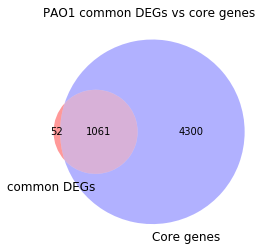

In [11]:
pao1_core_common_venn = venn2(
    [pao1_common_DEGs_set, pao1_core_set], set_labels=("common DEGs", "Core genes")
)

pao1_core_common_venn.get_patch_by_id("11").set_color("purple")
pao1_core_common_venn.get_patch_by_id("11").set_edgecolor("none")
pao1_core_common_venn.get_patch_by_id("11").set_alpha(0.3)
pao1_core_common_venn.get_patch_by_id("01").set_color("blue")
pao1_core_common_venn.get_patch_by_id("01").set_edgecolor("none")
pao1_core_common_venn.get_patch_by_id("01").set_alpha(0.3)

plt.title("PAO1 common DEGs vs core genes")

# Save figure
matplotlib.pyplot.savefig(
    "pao1_common_core_venn.svg",
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

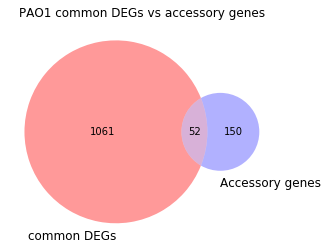

In [12]:
pao1_acc_common_venn = venn2(
    [pao1_common_DEGs_set, pao1_acc_set], set_labels=("common DEGs", "Accessory genes")
)

pao1_acc_common_venn.get_patch_by_id("11").set_color("purple")
pao1_acc_common_venn.get_patch_by_id("11").set_edgecolor("none")
pao1_acc_common_venn.get_patch_by_id("11").set_alpha(0.3)
pao1_acc_common_venn.get_patch_by_id("01").set_color("blue")
pao1_acc_common_venn.get_patch_by_id("01").set_edgecolor("none")
pao1_acc_common_venn.get_patch_by_id("01").set_alpha(0.3)

plt.title("PAO1 common DEGs vs accessory genes")

# Save figure
matplotlib.pyplot.savefig(
    "pao1_common_acc_venn.svg",
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

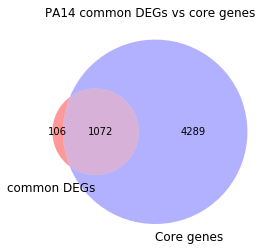

In [13]:
pa14_core_common_venn = venn2(
    [pa14_common_DEGs_set, pa14_core_set], set_labels=("common DEGs", "Core genes")
)

pa14_core_common_venn.get_patch_by_id("11").set_color("purple")
pa14_core_common_venn.get_patch_by_id("11").set_edgecolor("none")
pa14_core_common_venn.get_patch_by_id("11").set_alpha(0.3)
pa14_core_common_venn.get_patch_by_id("01").set_color("blue")
pa14_core_common_venn.get_patch_by_id("01").set_edgecolor("none")
pa14_core_common_venn.get_patch_by_id("01").set_alpha(0.3)

plt.title("PA14 common DEGs vs core genes")

# Save figure
matplotlib.pyplot.savefig(
    "pa14_common_core_venn.svg",
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

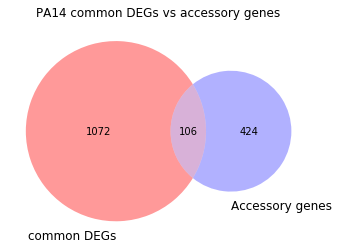

In [14]:
pa14_acc_common_venn = venn2(
    [pa14_common_DEGs_set, pa14_acc_set], set_labels=("common DEGs", "Accessory genes")
)

pa14_acc_common_venn.get_patch_by_id("11").set_color("purple")
pa14_acc_common_venn.get_patch_by_id("11").set_edgecolor("none")
pa14_acc_common_venn.get_patch_by_id("11").set_alpha(0.3)
pa14_acc_common_venn.get_patch_by_id("01").set_color("blue")
pa14_acc_common_venn.get_patch_by_id("01").set_edgecolor("none")
pa14_acc_common_venn.get_patch_by_id("01").set_alpha(0.3)

plt.title("PA14 common DEGs vs accessory genes")

# Save figure
matplotlib.pyplot.savefig(
    "pao1_common_acc_venn.svg",
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

## Enrichment test

The [Fisher's exact test](https://en.wikipedia.org/wiki/Fisher%27s_exact_test) determines whether there is a significant association between two categorical variables in a contingency table (i.e two classifications of the data). Here we used use the Fisher’s exact test to determine if there is an association between the two classifications: common vs uncommon and core vs accessory. In other words, we want to determine if there is a statistically significant association between gene group and if a gene is common DEG. To do this we compare the ratio of core vs accessory genes that are common DEGs are significantly different to the ratio of core vs accessory that are not common DEGs.

Since the numbers are large, we also applied the $\chi^2$ test as an alternative to the Fisher's exact test.

In [15]:
# Make contingency table for PAO1 data
# -----|common DEG   |not common DEGs
# core | # genes     | # genes
# acc  | # genes     | # genes

# Get not-common DEGs
all_pao1_genes = set(pao1_expression.columns)
not_common_DEGs_set = all_pao1_genes.difference(pao1_common_DEGs_set)

# Make components of contingency table
common_core_genes = pao1_common_DEGs_set.intersection(pao1_core_set)
common_acc_genes = pao1_common_DEGs_set.intersection(pao1_acc_set)
not_common_core_genes = not_common_DEGs_set.intersection(pao1_core_set)
not_common_acc_genes = not_common_DEGs_set.intersection(pao1_acc_set)

pao1_observed_contingency_table = np.array(
    [
        [len(common_core_genes), len(not_common_core_genes)],
        [len(common_acc_genes), len(not_common_acc_genes)],
    ]
)
pao1_observed_contingency_table

array([[1061, 4300],
       [  52,  150]])

In [16]:
# Save common core and acc gene to new var
pao1_common_core = common_core_genes
pao1_common_acc = common_acc_genes

In [17]:
# Make contingency table for PAO1 data
# -----|common DEG   |not common DEGs
# core | # genes     | # genes
# acc  | # genes     | # genes

# Get not-common DEGs
all_pa14_genes = set(pa14_expression.columns)
not_common_DEGs_set = all_pa14_genes.difference(pa14_common_DEGs_set)

# Make components of contingency table
common_core_genes = pa14_common_DEGs_set.intersection(pa14_core_set)
common_acc_genes = pa14_common_DEGs_set.intersection(pa14_acc_set)
not_common_core_genes = not_common_DEGs_set.intersection(pa14_core_set)
not_common_acc_genes = not_common_DEGs_set.intersection(pa14_acc_set)

pa14_observed_contingency_table = np.array(
    [
        [len(common_core_genes), len(not_common_core_genes)],
        [len(common_acc_genes), len(not_common_acc_genes)],
    ]
)
pa14_observed_contingency_table

array([[1072, 4289],
       [ 106,  424]])

In [18]:
# Save common core and acc gene to new var
pa14_common_core = common_core_genes
pa14_common_acc = common_acc_genes

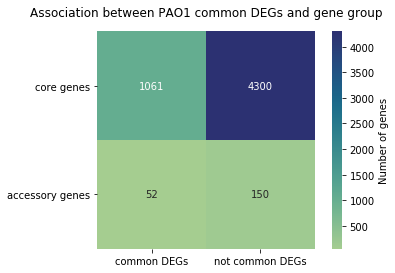

In [19]:
# Make heatmap of contingency table for PAO1
pao1_observed_contingency_table_df = pd.DataFrame(
    data=pao1_observed_contingency_table,
    index=["core genes", "accessory genes"],
    columns=["common DEGs", "not common DEGs"],
)
f = sns.heatmap(
    pao1_observed_contingency_table_df,
    cmap=sns.color_palette("crest", as_cmap=True),
    cbar_kws={"label": "Number of genes"},
    square=True,
    annot=True,
    fmt=".4g",
)
f.set_yticklabels(f.get_yticklabels(), rotation=0)
f.set_title("Association between PAO1 common DEGs and gene group", pad=15)

# Save figure
f.figure.savefig(
    "pao1_common_vs_gene_group_contingency_table.svg",
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

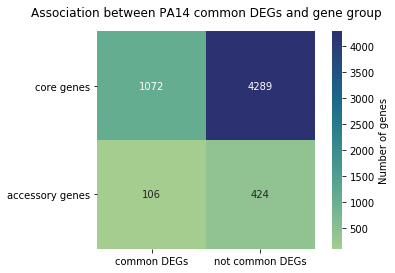

In [20]:
# Make heatmap of contingency table for PAO1
pa14_observed_contingency_table_df = pd.DataFrame(
    data=pa14_observed_contingency_table,
    index=["core genes", "accessory genes"],
    columns=["common DEGs", "not common DEGs"],
)
f = sns.heatmap(
    pa14_observed_contingency_table_df,
    cmap=sns.color_palette("crest", as_cmap=True),
    cbar_kws={"label": "Number of genes"},
    square=True,
    annot=True,
    fmt=".4g",
)
f.set_yticklabels(f.get_yticklabels(), rotation=0)
f.set_title("Association between PA14 common DEGs and gene group", pad=15)

# Save figure
f.figure.savefig(
    "pa14_common_vs_gene_group_contingency_table.svg",
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

In [21]:
# The two-sided p-value is the probability that, under the null hypothesis,
# a random table would have a probability equal to or less than the probability of the input table.
# The probability that we would observe this or an even more imbalanced ratio by chance is ~4%

# There is a negative association based on the odds ratio with a slightly significant p-value
pao1_oddsr, pao1_pval = scipy.stats.fisher_exact(
    pao1_observed_contingency_table, alternative="two-sided"
)

print(pao1_oddsr, pao1_pval)

0.7117620751341681 0.048168415410358205


In [22]:
# There is a negative association based on the odds ratio with a slightly significant p-value
pa14_oddsr, pa14_pval = scipy.stats.fisher_exact(
    pa14_observed_contingency_table, alternative="two-sided"
)

print(pa14_oddsr, pa14_pval)

0.9997668454185125 1.0


In [23]:
# Alternatively we can use chi^2 test, which is more suitable for larger values
pao1_chi2, pao1_pval, pao1_dof, pao1_expected_counts = scipy.stats.chi2_contingency(
    pao1_observed_contingency_table
)

print(pao1_chi2, pao1_pval)

3.944422957638438 0.04702697976184229


In [24]:
pa14_chi2, pa14_pval, pa14_dof, pa14_expected_counts = scipy.stats.chi2_contingency(
    pa14_observed_contingency_table
)

print(pa14_chi2, pa14_pval)

0.0030109834038058707 0.9562400976851566


### Compare against previous publication
Let's compare our results to those published by [Balasubramanian et al. 2009](https://link.springer.com/article/10.1186/1479-7364-3-4-361#Sec17), who found a set of genes that were commonly DE across multiple stress responses and that 90% of them were found in core genes.
They found 303 commonly DEGs, of which 29 of were accessory genes. We want to compare this finding to our own.

Some implementation notes:
* core and PAO1 accessory genes are defined by [Mathee et al. 2008](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2268591/) Supplementary figure 6.
* 5,021 core genes
* 91 accessory genes

Balasubramanian et al. 2009 claims that these common DEGs are mostly found in core genes based on the proportion of common genes that are core genes. However, if we peform $\chi^2$ test, like we did here, then we get consistent results that there is a relationship between common and accessory genes.

_Why are we using $\chi^2$-test?_
* Since we are asking “how likely are core genes to be common?” We need to consider the uncommon genes as well because despite core genes being found in high proportion of common genes, this proportion could be equally high in uncommon genes.
* The other reason to use this test is to account for the skewing in the number of genes in each gene group. There are many more core genes than accessory genes so there are more chances for core genes to be found to overlap with common genes. By looking at the proportion of common vs uncommon amongst the core genes and common vs uncommon in the accessory genes we are indirectly taking into account the total number of genes in each gene group

In [25]:
pub_contingency_table = [[274, 5021 - 274], [29, 91]]
pub_oddsr, pub_pval = scipy.stats.fisher_exact(
    pub_contingency_table, alternative="two-sided"
)

print(pub_oddsr, pub_pval)

0.1811234681795399 2.559698038789663e-11


### Who are these genes?

Let's look at the core and accessory genes that are also common DEGs

In [26]:
# Load core-core annotations and select only the genes that are common DEGs
pao1_core_summary_annot_filename = (
    "../3_core_core_analysis/pao1_core_similarity_associations_final_spell.tsv"
)
pa14_core_summary_annot_filename = (
    "../3_core_core_analysis/pa14_core_similarity_associations_final_spell.tsv"
)

pao1_core_summary_annot = pd.read_csv(
    pao1_core_summary_annot_filename, sep="\t", index_col=0, header=0
)
pa14_core_summary_annot = pd.read_csv(
    pa14_core_summary_annot_filename, sep="\t", index_col=0, header=0
)

Note: There are some common core genes that are **not found** in our core-core annotation summary table. This is because of the processing that was performed in [1_core_core_relationships_across_strains.ipynb](../3_core_core_analysis/1_core_core_relationships_across_strains.ipynb) where we were mapping PAO1 genes to their homologous PA14 gene and comparing their transcriptional relationships. Some genes were removed because they mapped to multiple PA14 genes. Genes are also removed if the gene was not found in the PAO1 or PA14 compendia. Similarly for mapping from PA14 to PAO1, there were some genes that were lost due to this processing. So we will use the intersection of gene ids here.

In [27]:
# Get shared genes
shared_pao1_core_ids = set(pao1_common_core).intersection(pao1_core_summary_annot.index)
shared_pa14_core_ids = set(pa14_common_core).intersection(pa14_core_summary_annot.index)

In [28]:
pao1_common_core_df = pao1_core_summary_annot.loc[shared_pao1_core_ids]

In [29]:
pa14_common_core_df = pa14_core_summary_annot.loc[shared_pa14_core_ids]

In [30]:
# Load acc-acc annotations and select only the genes that are common DEGs
pao1_acc_summary_annot_filename = (
    "../4_acc_acc_analysis/pao1_acc_gene_module_annotated_affinity_spell.tsv"
)
pa14_acc_summary_annot_filename = (
    "../4_acc_acc_analysis/pa14_acc_gene_module_annotated_affinity_spell.tsv"
)

pao1_acc_summary_annot = pd.read_csv(
    pao1_acc_summary_annot_filename, sep="\t", index_col=0, header=0
)
pa14_acc_summary_annot = pd.read_csv(
    pa14_acc_summary_annot_filename, sep="\t", index_col=0, header=0
)

In [31]:
pao1_common_acc_df = pao1_acc_summary_annot.loc[pao1_common_acc]

In [32]:
pa14_common_acc_df = pa14_acc_summary_annot.loc[pa14_common_acc]

In [33]:
# Save
pao1_common_core_df.to_csv("pao1_common_core_gene_annot.tsv", sep="\t")
pa14_common_core_df.to_csv("pa14_common_core_gene_annot.tsv", sep="\t")

pao1_common_acc_df.to_csv("pao1_common_acc_gene_annot.tsv", sep="\t")
pa14_common_acc_df.to_csv("pa14_common_acc_gene_annot.tsv", sep="\t")

**Takeaway:**

Here our null hypothesis is that common DEGs are equally likely to be core or accessory genes.
In order to calculate the significance of the observed data, i.e. the total probability of observing data as extreme or more extreme if the null hypothesis is true using the Fisher's exact test.
We found that the percentage of PAO1 core genes that are common is ~25% compared to ~34% accessory genes. In PA14, the percentage of core genes that are common is ~25% compared to ~25% accessory genes.

Overall, in PAO1 common genes are more likely to be accessory. The genes commonly differentially expressed in response to these stress conditions, are changes that are commonly needed for _P. aeruginosa_ to establish itself within the host.
So it makes sense that these genes are biased towards being accessory genes, which are acquired genes that, in part, to allow _P. aeruginosa_ to adapt to different environments.
In PA14 common genes are equally likely to be core or accessory, there is no relationship.